# Locality Biases A: Localized Noise Injection 

We have previously evaluated the accuracy of our finetuned discriminative models and contrastive models on the test set of the CIFAR-10 dataset. Now we aim to understand the reliance of the models on local and global information. In this notebook, we develop a noise-injected manipulation of the CIFAR-10 test set to investigate how localized noise affects model performance. The goal is to inject Gaussian noise into a small 8x8 patch in each of the images to simulate localized corruption in the images. For the sake of fairness in evaluation, we apply the noise in consistent manner across all images in the test set, i.e., the same noise pattern and location are used while injecting noise in all the images. 

**Since we have already obtained the model accuracies on the clean test set, the drop in performance of each model on the noised test-set prepared in this notebook will indicate how robust the models are to localized noise.**

### Setup/Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=10000, shuffle=False)

test_images, test_labels = next(iter(test_loader))

print(f'Test set size: {test_images.shape}')

100%|██████████| 170498071/170498071 [00:12<00:00, 13248898.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Test set size: torch.Size([10000, 3, 32, 32])


### Noise Injection

Now that we have loaded all 10,000 images from the test set (32x32), we define the noise injection logic in the `apply_localized_noise` method. Gaussian noise is generated with mean = 0 and std dev = 0.5 and applied to an 8x8 random patch within each image. All images have the same random noise patch applied to them.

In [3]:
def apply_localized_noise(images, patch_size=8, noise_mean=0, noise_std=0.5):

    batch_size, channels, height, width = images.shape

    patch_x = np.random.randint(0, height - patch_size) # randomly choosing a top-left corner for the 8x8 patch
    patch_y = np.random.randint(0, width - patch_size)

    noise = torch.randn((batch_size, channels, patch_size, patch_size)) * noise_std + noise_mean

    images[:, :, patch_x:patch_x+patch_size, patch_y:patch_y+patch_size] += noise # applying noise to the same 8x8 patch in all images
    images = torch.clamp(images, 0, 1)

    return images, (patch_x, patch_y)

noised_images, patch_location = apply_localized_noise(test_images.clone())
print(f'Localized noise applied to patch at (x={patch_location[0]}, y={patch_location[1]})')

Localized noise applied to patch at (x=8, y=7)


In [5]:
def imshow(clean_img, noisy_img):

    _, axs = plt.subplots(1, 2, figsize=(8, 4))

    npimg_clean = clean_img.numpy()
    axs[0].imshow(np.transpose(npimg_clean, (1, 2, 0)))
    axs[0].set_title("Clean Image")

    npimg_noisy = noisy_img.numpy()
    axs[1].imshow(np.transpose(npimg_noisy, (1, 2, 0)))
    axs[1].set_title("Noisy Image")

    for ax in axs:
        ax.axis('off')

    plt.show()

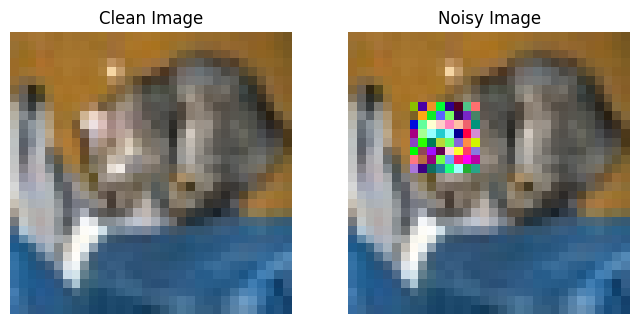

In [6]:
clean_image = test_images[0]
noisy_image = noised_images[0]

imshow(clean_image, noisy_image)

### Noised Dataset Definition

In [7]:
class NoisedCIFAR10Dataset(torch.utils.data.Dataset):

    def __init__(self, original_dataset, noised_images):

        self.original_dataset = original_dataset
        self.noised_images = noised_images

    def __len__(self):

        return len(self.original_dataset)

    def __getitem__(self, idx):

        image = self.noised_images[idx]
        label = self.original_dataset.targets[idx]

        return image, label

noised_CIFAR_10_test_set = NoisedCIFAR10Dataset(test_set, noised_images)
noised_test_loader = torch.utils.data.DataLoader(noised_CIFAR_10_test_set, batch_size=100, shuffle=False)

print("Noised CIFAR-10 test set created successfully!")

Noised CIFAR-10 test set created successfully!


### Optional: Export Noised Dataset As Zip

In [8]:
import os
import shutil
from google.colab import files

output_dir = 'noised_cifar10_test'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def save_images(noised_images, labels, directory):

    classes = test_set.classes

    for idx, (img, label) in enumerate(zip(noised_images, labels)):

        class_name = classes[label]
        class_dir = os.path.join(directory, class_name)

        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        img_np = np.transpose(img.numpy(), (1, 2, 0))

        image_path = os.path.join(class_dir, f'{idx}.png')

        plt.imsave(image_path, img_np)

    print(f"All images saved in {directory}")

save_images(noised_images, test_labels, output_dir)
shutil.make_archive(output_dir, 'zip', output_dir)
files.download(f'{output_dir}.zip')

All images saved in noised_cifar10_test


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>